**This notebook generates figures and MAB estimates to the use in the EMAC presentation.
User types are static in this version.**



    

In [1]:
#Run parameters
#used to control every run. Can be user to perfom sensitivity checks
path_dir = r"/Users/../Volumes/Raw/"

low_success = 0.5 #below the median: unsuccessful
high_success = 0.9 #top 10% creators with more followers are deemed successful

low_user_outdegree = 0.25 
high_user_outdegree = 0.75 
low_user_activity = 0.25 
high_user_activity = 0.75 

activity_filter = 0

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from collections import Counter
from src.utils import import_dta, import_tracks_dta,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import numpy as np
import datetime
import pandas as pd
from tqdm import tqdm
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import os
from statsmodels.stats.proportion import proportions_ztest

In [3]:
def process_date(date):
    '''convert date format like '2013-w09' to '2013-03-04', i.e. the first day of that week'''
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.datetime.strptime(date, "%Y-%W-%w")
    return dt

# Data Imports

We start by importing the raw data.  `follows_sent`, `comments_sent`, `shares_sent`, `likes_sent` and `messages_sent` contains data pn the promotional activities that the 35k users tracked in the dataset directed to other users. It includes the `user_id`, the `fan_id` and the `date_sent` which identifies the date when the prom. activity was sent. `users_info_1st` shows the type of user (creator or non-creator, which is identified by a blank) and the date the user entered the platform, for every user that sent or received prom. activities from any of the 35k users tracked in this dataset, while `users_info` contains the same information, but pertaining to the 35k users themselves.

`follows_received` contains information on the follows received by the 35k users and will be used to generate the successful/unsuccessful groups of content creators.

In [4]:
#affiliations :follows
#favoritings :likes

#used in filtering:
path_dir = r"/Users/../Volumes/Raw/"
tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");

#these are the actions sent to 
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

#Used to track information on the 1st degree connections
user_info_1st = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_1st.columns = ['user_id', 'type', 'entered_platform'];
user_info = import_dta(path_dir, "12sample_user_infos.dta");

#Used to compute creator's success measure
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)


Indegree and outdegree information.

The function below import the outdegree dataset. Because the raw version of those dataset are too large to be processed in memory, we preprocessed them in a separate script.

In [5]:
# Aggregates preprocessed outdegree of 1st degree users
def import_outdegree(path='/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/'):
    d = {}
    for i in range(6):
       d[str(i)] = pd.read_pickle(os.path.join(path,'{}.pkl'.format(i))) 
       d[str(i)]['created_at'] =  pd.to_datetime(d[str(i)]['created_at'])
       d[str(i)]['created_at'] = pd.to_datetime(d[str(i)]['created_at']).dt.floor('d')
       d[str(i)] = d[str(i)].groupby(['sender_id', 'created_at'], as_index = False).size() 
    
    data_outdegree = pd.concat([d['0'], d['1'], d['2'], d['3'], d['4'], d['5']])
    #data_outdegree.set_index('created_at', inplace = True)
    return data_outdegree

In [6]:
data_outdegree = import_outdegree()

In [7]:
#data_outdegree = data_outdegree.groupby(['sender_id','created_at'], as_index = False).size()

# Preprocessing

## Creator ids, successful and unsucessful creators

Next, we define three lists of ids: one with the ids from the content creators, according to the `users_info` table, one with the ids of successful creators and the last one with the ids of the unsuccessful ones.

Let's start with a list of the id of creators. We also create a dataset with containing information on creators only.

In [8]:
mask = (tracks.track_available == 1) & (tracks.public == 't')
creator_ids = tracks[mask].user_id.unique()

creators = tracks[(tracks.track_available == 1) & (tracks.public == 't')]

#mask = user_info.type == 'creator'
#creator_ids = user_info[mask].user_id.unique()

#creators = user_info[user_info.type == 'creator']

## Putting together a dataset with the promotional activities made by content creators.

The function `gen_actions_sent_df` creates a dataframe with all the promotional activities that content creators sent to users.

In [9]:
def gen_actions_sent_df(follows_sent, shares_sent, likes_sent, comments_sent, messages_sent, creator_ids = creator_ids):
    '''
    Creates dataframe containing the actions that content creators send to users.
        Attributes:
                    follows_sent:  dataframe with the follows sent by the 35k users.
                    shares_sent:   dataframe with the shares sent by the 35k users.
                    likes_sent:    dataframe with the likes sent by the 35k users.
                    comments_sent: dataframe with the comments sent by the 35k users.
                    messages_sent: dataframe with the messages sent by the 35k users.
                    creator_ids:   list with content creator ids. If not none, is used to
                                   filter out activities from non creators.
    '''
    
    follows_sent['outbound_activity'] = 'follow'
    follows_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'song_id' in shares_sent.columns:
        shares_sent.drop(columns=["song_id"])
    shares_sent = shares_sent[['reposter_id', "owner_id", 'created_at']]
    shares_sent['outbound_activity'] = 'repost'
    shares_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'track_id' in likes_sent.columns:
        likes_sent.drop(columns=["track_id"], inplace=True)
    likes_sent['outbound_activity'] = 'like'
    likes_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'track_id' in comments_sent.columns:
        comments_sent.drop(columns=["track_id"], inplace=True)
    comments_sent['outbound_activity'] = 'comment'
    comments_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    messages_sent["outbound_activity"] = 'message'
    messages_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']
    df = pd.concat([follows_sent, shares_sent, likes_sent, comments_sent, messages_sent])


    if type(creator_ids) == numpy.ndarray:
        df = df[df['user_id'].isin(creator_ids)]
        
    df['week_yr'] = df.date_sent.dt.strftime('%Y-w%U')
    df = df.loc[df['user_id'] != df['fan_id'],:]

    return df

In [10]:
actions_sent = gen_actions_sent_df(follows_sent, shares_sent, likes_sent, comments_sent,
                                     messages_sent, creator_ids = None)

In [11]:
active_users_ids = actions_sent.groupby('user_id', as_index = False).size()
mask = active_users_ids['size']>= activity_filter
active_users_ids = active_users_ids[mask].user_id.unique()

In [40]:
def successful_creators_followers(follows_received, base_date = datetime.datetime(2016, 5, 30, 0, 0), perc1 = None, perc2 = None, subset_creators = None):
    '''Classifies content creators in successful or unsuccessfull
        Arguments:
                    follows_received: dataframe containing the follows received by content creators
                    base date:        date, in datetime.datetime(YYYY, M, DD, H, M) format, in which the number 
                                      of followers per creator is calculated.
                    perc1:            the threshold used to classify unsuccessful content creators. Creator having 
                                      total followers below the number dictated by this threshold, at the base date,
                                      are classified as unsuccessful 
                    perc2:            the threshold used to classify successful content creators. Creator having 
                                      total followers above the number dictated by this threshold, at the base date,
                                      are classified as successful
                    subset_creators:  a pd.DataFrame containing the creators. If is it available, it will be used to 
                                      filter out non creators and to make sure creators with 0 followers are part of
                                      the resulting dataset.
        
    '''
    print(base_date)

    if 'inbound_activity' not in follows_received.columns:
        follows_received.columns = ['fan_id', 'user_id', 'date_sent']

    mask = (follows_received['date_sent'] < base_date)

    df = follows_received[mask].groupby('user_id', as_index=False).agg({'fan_id': pd.Series.nunique})
    df.columns = ['user_id', 'followers']

    
    if type(subset_creators) == pd.DataFrame:
        print('subsetting...')
        df.set_index('user_id', inplace = True)
        df = df.reindex(subset_creators.user_id.unique())
        df.fillna(0, inplace = True)
        df.reset_index(inplace = True)
        df.columns = ['user_id', 'followers']
        
    mask = df.user_id.isin(active_users_ids)
    df = df[mask]

    low = np.quantile(df.followers, perc1)
    high = np.quantile(df.followers, perc2)

    print("High influencer boundary: {}".format(high))
    print("Low influencer boundary: {}".format(low))

    mask = (df["followers"] <= low) | (df["followers"] >= high)
    
    unsuccessful_creator_ids = df.loc[df["followers"] <= low].user_id.unique()
    successful_creator_ids = df.loc[df["followers"] >= high].user_id.unique()

    return unsuccessful_creator_ids, successful_creator_ids


In [41]:
unsuccessful_ids, successful_ids = successful_creators_followers(follows_received, 
                                                        perc1 = low_success, perc2 = high_success, subset_creators = creators)


2016-05-30 00:00:00
subsetting...
High influencer boundary: 81.0
Low influencer boundary: 13.0


In [14]:
print(len(unsuccessful_ids))
print(len(successful_ids))

1959
389


In [15]:
creators.user_id.nunique()

4604

## Filter only actions that were sent to non-fans

We merge the `actions_sent` dataset with a table containing the date each fan started following the creator.

In [16]:
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follows_received[["fan_id", "user_id", "date_sent"]]
followers.columns = ["fan_id", "user_id", "follower_since"]

actions_sent = actions_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

Since we are interested in acquisition campaings, we need to produce a dataset that exclude actions targetting fans.
We do that using filters based on the date of the action and the date that the user became a fan of the content creator. The resulting dataframe is named `actions_sent_non_fans`.

We then filter only actions that happened before the user follows the content creator.

In [17]:
#mask = (actions_sent.date_sent < actions_sent.follower_since) | (actions_sent.follower_since.isnull())
#actions_sent_non_fans =  actions_sent[mask]
#actions_sent_non_fans['week_yr_date'] = actions_sent_non_fans.week_yr.apply(lambda x: process_date(x))

## Outdegree level

Originally, we only have outdegree information on users that follow at least one user. The function below inputs an outdegree of 0 to users that are following anyone.

In [27]:
#CHANGE DOCUMENTATION
def outdegree_level(data, date, user_info = user_info_1st):
    
    '''
    This function returns the membership table at date equals `date`. Every user that interacted with the 35k tracked 
    users and entered the platform before `date` is present in the table, even if it has indegree 0.
    arguments:
              data:           the indegree dataset.
              user_info:      the dataset containing all the users that interacted with the 35k users tracked.
    '''
    
    data = data[data.created_at.dt.floor('d')<=date]
    data = data.groupby('sender_id').agg({'size':'sum'}).compute()
    
    #merge with user info to obtain users that are not followed by anyone at the current date
    data = user_info_1st.merge(data, left_on = 'user_id', right_on = 'sender_id', how= 'outer')
    data.loc[data['size'].isnull(), 'size'] = 0
    data = data[['user_id', 'size', 'entered_platform']].set_index('user_id')
    
    #filter out users that didnt exist in the current date
    mask = data['entered_platform'].dt.floor('d') <= date
    data = data.loc[mask]
    
    mask = (data['size']>0)
    data.loc[~mask, 'size'] = 0 
    
    return data

In [25]:
#dask is a python api with objects optimized for big data (user directed acyclic graphs). 
dask_outdegree = dd.from_pandas(data_outdegree, npartitions = 3)

In [28]:
last_day =  max(actions_sent.date_sent.dt.floor('d').unique())
user_outdegree = outdegree_level(dask_outdegree, last_day, user_info = user_info_1st)

Now we classify the creator in successful and unsuccessful, according to the threshold defined in the beggining of this notebook.

In [29]:
def user_outdegree_level(oudegree_data, perc1 = None, perc2 = None):
    '''Classifies content creators in successful or unsuccessfull
        Arguments:
                    oudegree_data:    dataframe containing the fans followers at 
                    perc1:            the threshold used to classify unsuccessful content creators. Creator having 
                                      total followers below the number dictated by this threshold, at the base date,
                                      are classified as unsuccessful 
                    perc2:            the threshold used to classify successful content creators. Creator having 
                                      total followers above the number dictated by this threshold, at the base date,
                                      are classified as successful
    '''

    df = oudegree_data.reset_index().iloc[:,:2]
    df.columns = ['user_id', 'followers']

    low = np.quantile(df.followers, perc1)
    high = np.quantile(df.followers, perc2)

    print("High outdegree boundary: {}".format(high))
    print("Low outdegree boundary: {}".format(low))
    
    low_outdegree_ids = df.loc[df["followers"] <= low].user_id.unique()
    high_outdegree_ids = df.loc[df["followers"] >= high].user_id.unique()
    
    
    df['outdegree_level'] = df.user_id.apply(
        lambda x: 'high' if x in high_outdegree_ids else ('low' if x in low_outdegree_ids else None))

    
    return df, low_outdegree_ids, high_outdegree_ids

In [30]:
user_outdegree_df, low_outdegree_ids, high_outdegree_ids = user_outdegree_level(user_outdegree,
                perc1 = low_user_outdegree, perc2 = high_user_outdegree)

High outdegree boundary: 162.0
Low outdegree boundary: 17.0


In the cell below, we create a list with unique ids from users that appear in the oudegree level table. This will later be uses to construct a flow-chart indicating how we lose data based on filters and operations.

In [31]:
receiver_ids = user_outdegree.index.unique()

## Non-follow Actions level

The activity level is defined as the number of actions performed by users. It is important to notice that we only observe actions targeting the 35k users that joined in march 2012. We consider this measure a proxy for the real activity level.

Let's begin by creating a dataset with all action received by those 35k users.

In [12]:
path_dir_2 = r'/Users/../Volumes/Alter_outbound_activities/'

comments_received = import_dta(path_dir_2, "12sample_1st_deg_comments_made.dta");
shares_received = import_dta(path_dir_2, "12sample_1st_deg_reposts_made.dta");
likes_received = import_dta(path_dir_2, "12sample_1st_deg_favoritings_made.dta");
messages_received = import_dta(path_dir_2, "12sample_1st_deg_messages_sent.dta");

#comments_received = import_dta(path_dir, "12sample_comments_received.dta");
#shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
#likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
#messages_received = import_dta(path_dir, "12sample_messages_received.dta");

%%%%%%%%%% 12sample_1st_deg_comments_made.dta %%%%%%%%%%
(21463011, 4)
%%%%%%%%%% 12sample_1st_deg_reposts_made.dta %%%%%%%%%%
(18953640, 4)
%%%%%%%%%% 12sample_1st_deg_favoritings_made.dta %%%%%%%%%%
(86793370, 4)
%%%%%%%%%% 12sample_1st_deg_messages_sent.dta %%%%%%%%%%
(16824074, 3)


In [13]:
if 'song_id' in shares_received:
        shares_received.drop(columns=["song_id"])
shares_received = shares_received[['reposter_id', "owner_id", 'created_at']]
shares_received['inbound_activity'] = 'repost'
shares_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

if 'track_id' in likes_received:
        likes_received = likes_received.drop(columns=["track_id"])
likes_received['inbound_activity'] = 'like'
likes_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

if 'track_id' in comments_received:
        comments_received = comments_received.drop(columns=["track_id"])
comments_received['inbound_activity'] = 'comment'
comments_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

messages_received["outbound_activity"] = 'message'
messages_received.columns = ['user_id', 'fan_id', 'date_sent', 'inbound_activity']

In [14]:
user_activity_data = pd.concat([shares_received, likes_received, comments_received, messages_received])

In [15]:
def user_activity_level(user_activity_data, receiver_ids, perc1 = None, perc2 = None):
    '''Classifies users based on the amount of non-follow activities
        Arguments:
                    user_activity_data:   dataframe containing the user activities 
                    base date:             date, in datetime.datetime(YYYY, M, DD, H, M) format, in which the number 
                                           of followers per creator is calculated.
                    perc1:                 the threshold used to classify unsuccessful content creators. Creator having 
                                           total followers below the number dictated by this threshold, at the base date,
                                           are classified as unsuccessful 
                    perc2:                 the threshold used to classify successful content creators. Creator having 
                                           total followers above the number dictated by this threshold, at the base date,
                                           are classified as successful
    '''

    df = user_activity_data.groupby('fan_id', as_index = True).size()
    df = df.reindex(receiver_ids)
    print(df.shape)
    df = df.reset_index()
    df.columns = ['user_id', 'activities_performed']
    
    df.loc[df.activities_performed.isna(), 'activities_performed'] = 0
    #classification should happen after this

    low = np.quantile(df.activities_performed, perc1)
    high = np.quantile(df.activities_performed, perc2)

    print("High activity boundary: {}".format(high))
    print("Low activity boundary: {}".format(low))
    
    low_activity_ids = df.loc[df["activities_performed"] <= low].user_id.unique()
    high_activity_ids = df.loc[df["activities_performed"] > high].user_id.unique()
    
    df['activity_level'] = df.user_id.apply(
    lambda x: 'high' if x in high_activity_ids else ('low' if x in low_activity_ids else None))

    return df, low_activity_ids, high_activity_ids

In [32]:
activity_level, low_activity_ids, high_activity_ids = user_activity_level(user_activity_data, receiver_ids, 
                perc1 = low_user_activity, perc2 = high_user_activity)

(670746,)
High activity boundary: 85.0
Low activity boundary: 1.0


Once more we create an object containing the unique ids of users in the resulting dataset. This will be used in a flow-chart, as explained.

In [33]:
activity_ids = np.append(low_activity_ids, high_activity_ids)

In [34]:
len(set(activity_ids).intersection(set(receiver_ids)))
#only 35493 from 240292 that follow at least one of the 35k, performed at least one non-follow action

360347

# Analysis

Now we merge the datasets with the outdegree, and non-follow activities information.

In [35]:
table_data = user_outdegree_df.merge(activity_level, left_on = 'user_id', right_on = 'user_id', how = 'inner')

In [36]:
table_data.groupby(['outdegree_level', 'activity_level']).size()

outdegree_level  activity_level
high             high              98464
                 low                7790
low              high               7266
                 low               85480
dtype: int64

And, finally, we create the 4 user groups that we are interested in: *Maven*, *Zombie*, *Stars* and *Stalker*. Everyone else is classified as *Other*.

In [37]:
table_data['Type'] = table_data.apply(lambda x: 
    'Focused-active' if (x.outdegree_level == 'low') & (x.activity_level == 'high')
     else ('Hermit' if (x.outdegree_level == 'low') & (x.activity_level == 'low')
     else ('Observer' if (x.outdegree_level == 'high') & (x.activity_level == 'low')
     else ('Widely-active' if (x.outdegree_level == 'high') & (x.activity_level == 'high')
     else 'other'))), axis=1)

Let's keep track of each user type's ids, as it gives us a compact way of identifying each user.

In [42]:
zombie_ids = table_data.loc[table_data.Type =='Hermit'].user_id.unique()
star_ids = table_data.loc[table_data.Type =='Widely-active'].user_id.unique()
maven_ids = table_data.loc[table_data.Type =='Focused-active'].user_id.unique()
stalker_ids = table_data.loc[table_data.Type =='Observer'].user_id.unique()

actions_sent['user_type'] = actions_sent.fan_id.apply(lambda x: 'Focused-active' if x in maven_ids else 
                          ('Hermit' if x in zombie_ids else
                          ('Observer' if x in stalker_ids else
                          ('Widely-active' if x in star_ids else 'other'))))

## classify content creators
actions_sent['creator_type'] = actions_sent.user_id.apply(
                                            lambda x: 'successful' if x in successful_ids else 
                                            ('unsuccessful' if x in unsuccessful_ids else 'other'))
actions_sent["day_yr_date"] = actions_sent.date_sent.dt.normalize()

In [43]:
actions_sent.loc[(actions_sent.outbound_activity == 'share'), 'outbound_activity'] = 'repost'

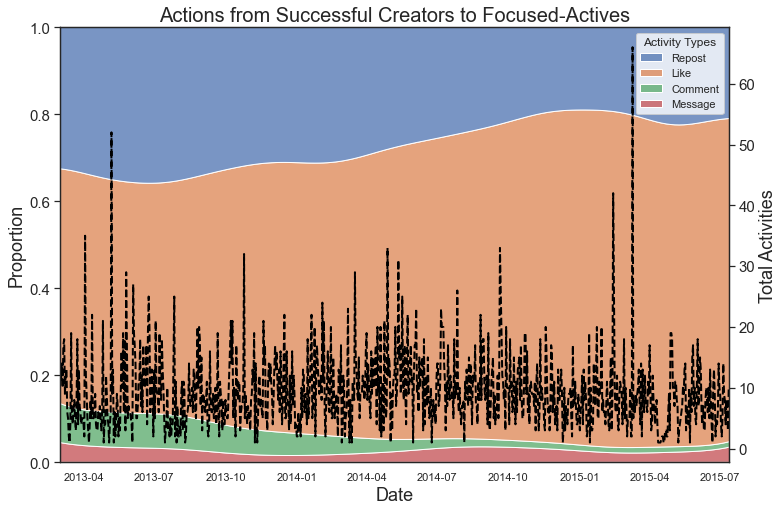

In [85]:
df = actions_sent.loc[(actions_sent.user_type == 'Focused-active')
                      &(actions_sent.creator_type == 'successful')
                      &(actions_sent.outbound_activity != 'follow'),:]
df.reset_index(inplace = True)

df.shape[0]

import seaborn as sns
hue_order_l = ['repost', 'like', 'comment', 'message']
lim_inf = min(df.date_sent)
lim_sup = max(df.date_sent)

df_grouped = df.groupby("day_yr_date", as_index = False).size()
window_size = 1
df_grouped['smoothed_size'] = pd.Series(df_grouped['size']).rolling(window_size, min_periods=1).mean()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=df,
            x="day_yr_date",
            hue='outbound_activity',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)\
.set(xlim=(lim_inf, lim_sup))
plt.ylabel('Proportion', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.title('Actions from Successful Creators to Focused-Actives', fontsize=20)
plt.yticks(fontsize = 15)

# Get a reference to the current legend
legend = plt.gca().get_legend()

# Set the new title for the legend
legend.set_title('Activity Types')

# Update the labels of the legend handles
for t in legend.texts:
    t.set_text(t.get_text().capitalize())

# Show the updated plot with the new legend title
    
ax2 = plt.twinx()
sns.lineplot(data=df_grouped,
            x = "day_yr_date", 
            y = "smoothed_size", 
            color="black", 
            ax=ax2, 
            legend = 'auto',
            linewidth = 2,
            linestyle = 'dashed')
plt.ylabel('Total Activities', fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

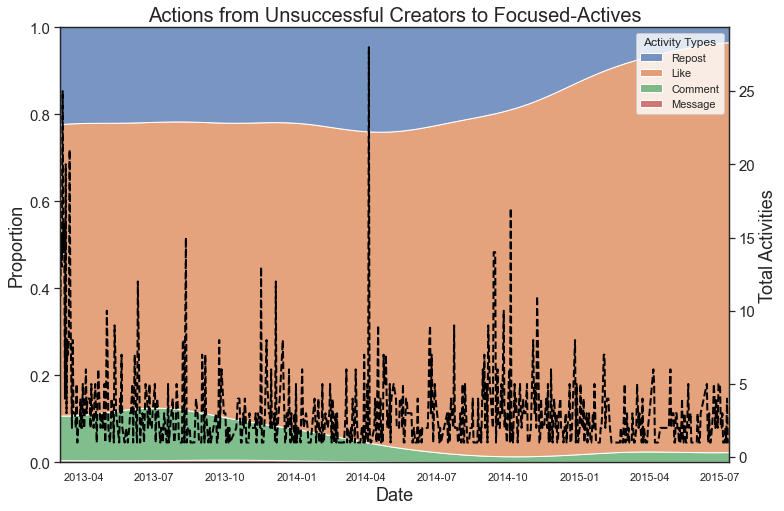

In [96]:
df = actions_sent.loc[(actions_sent.user_type == 'Focused-active')
                      &(actions_sent.creator_type == 'unsuccessful')
                      &(actions_sent.outbound_activity != 'follow'),:]
df.reset_index(inplace = True)

df.shape[0]

import seaborn as sns
hue_order_l = ['repost', 'like', 'comment', 'message']
lim_inf = min(df.date_sent)
lim_sup = max(df.date_sent)

df_grouped = df.groupby("day_yr_date", as_index = False).size()
window_size = 1
df_grouped['smoothed_size'] = pd.Series(df_grouped['size']).rolling(window_size, min_periods=1).mean()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=df,
            x="day_yr_date",
            hue='outbound_activity',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)\
.set(xlim=(lim_inf, lim_sup))
plt.ylabel('Proportion', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.title('Actions from Unsuccessful Creators to Focused-Actives', fontsize=20)
plt.yticks(fontsize = 15)

# Get a reference to the current legend
legend = plt.gca().get_legend()

# Set the new title for the legend
legend.set_title('Activity Types')

# Update the labels of the legend handles
for t in legend.texts:
    t.set_text(t.get_text().capitalize())

# Show the updated plot with the new legend title
    
ax2 = plt.twinx()
sns.lineplot(data=df_grouped,
            x = "day_yr_date", 
            y = "smoothed_size", 
            color="black", 
            ax=ax2, 
            legend = 'auto',
            linewidth = 2,
            linestyle = 'dashed')
plt.ylabel('Total Activities', fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

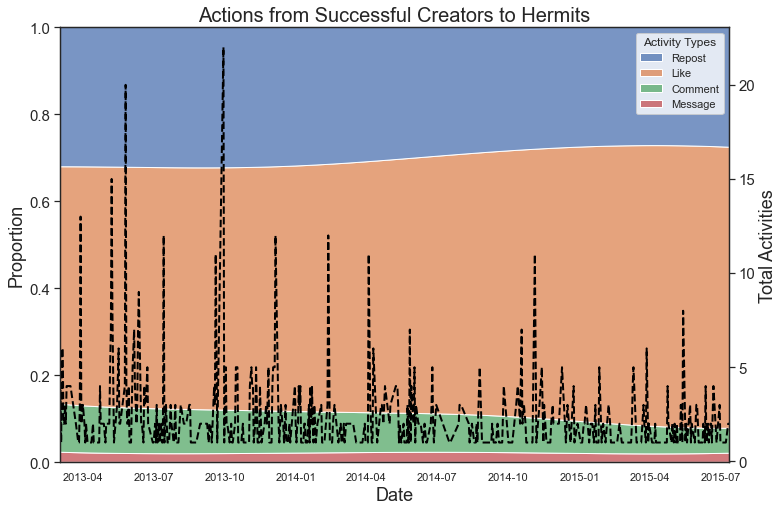

In [86]:
df = actions_sent.loc[(actions_sent.user_type == 'Hermit')&
                      (actions_sent.creator_type == 'successful')&
                      (actions_sent.outbound_activity != 'follow'),:]

df.reset_index(inplace = True)
df.shape[0]


import seaborn as sns
hue_order_l = ['repost', 'like', 'comment', 'message']
lim_inf = min(df.date_sent)
lim_sup = max(df.date_sent)

df_grouped = df.groupby("day_yr_date", as_index = False).size()
window_size = 1
df_grouped['smoothed_size'] = pd.Series(df_grouped['size']).rolling(window_size, min_periods=1).mean()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=df,
            x="day_yr_date",
            hue='outbound_activity',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 2)\
.set(xlim=(lim_inf, lim_sup))
plt.ylabel('Proportion', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.title('Actions from Successful Creators to Hermits', fontsize=20)
plt.yticks(fontsize = 15)

# Get a reference to the current legend
legend = plt.gca().get_legend()

# Set the new title for the legend
legend.set_title('Activity Types')

# Update the labels of the legend handles
for t in legend.texts:
    t.set_text(t.get_text().capitalize())

# Show the updated plot with the new legend title
    
ax2 = plt.twinx()
sns.lineplot(data=df_grouped,
            x = "day_yr_date", 
            y = "smoothed_size", 
            color="black", 
            ax=ax2, 
            legend = 'auto',
            linewidth = 2,
            linestyle = 'dashed')
plt.ylabel('Total Activities', fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

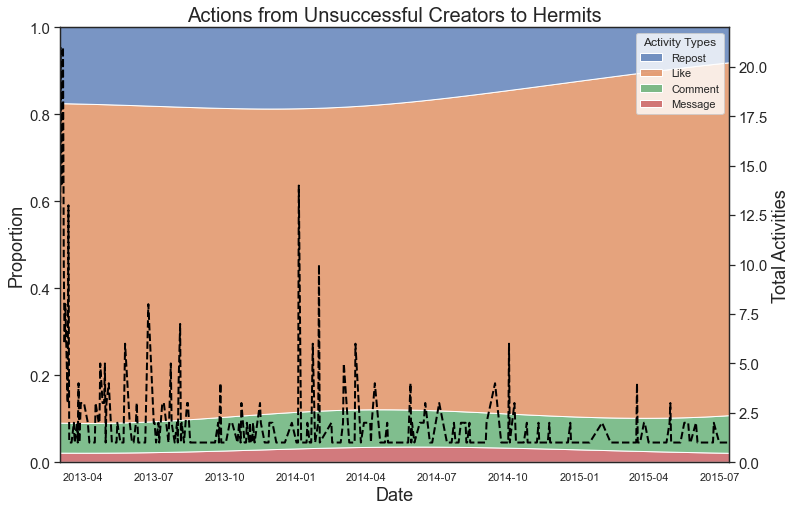

In [95]:
df = actions_sent.loc[(actions_sent.user_type == 'Hermit')&
                      (actions_sent.creator_type == 'unsuccessful')&
                      (actions_sent.outbound_activity != 'follow'),:]

df.reset_index(inplace = True)
df.shape[0]

import seaborn as sns
hue_order_l = ['repost', 'like', 'comment', 'message']
lim_inf = min(df.date_sent)
lim_sup = max(df.date_sent)

df_grouped = df.groupby("day_yr_date", as_index = False).size()
window_size = 1
df_grouped['smoothed_size'] = pd.Series(df_grouped['size']).rolling(window_size, min_periods=1).mean()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=df,
            x="day_yr_date",
            hue='outbound_activity',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 2)\
.set(xlim=(lim_inf, lim_sup))
plt.ylabel('Proportion', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.title('Actions from Unsuccessful Creators to Hermits', fontsize=20)
plt.yticks(fontsize = 15)

# Get a reference to the current legend
legend = plt.gca().get_legend()

# Set the new title for the legend
legend.set_title('Activity Types')

# Update the labels of the legend handles
for t in legend.texts:
    t.set_text(t.get_text().capitalize())

# Show the updated plot with the new legend title
    
ax2 = plt.twinx()
sns.lineplot(data=df_grouped,
            x = "day_yr_date", 
            y = "smoothed_size", 
            color="black", 
            ax=ax2, 
            legend = 'auto',
            linewidth = 2,
            linestyle = 'dashed')
plt.ylabel('Total Activities', fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

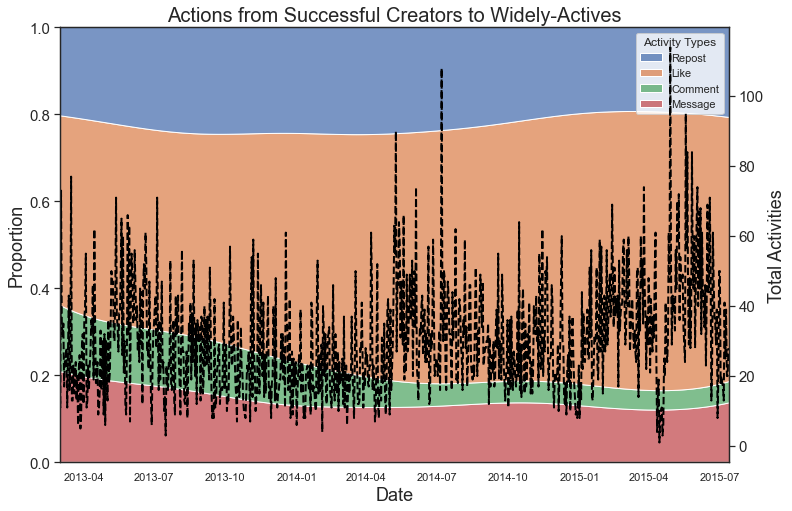

In [94]:
df = actions_sent.loc[(actions_sent.user_type == 'Widely-active')&
                      (actions_sent.creator_type == 'successful')&
                      (actions_sent.outbound_activity != 'follow'),:]

df.reset_index(inplace = True)
df.shape[0]


import seaborn as sns
hue_order_l = ['repost', 'like', 'comment', 'message']
lim_inf = min(df.date_sent)
lim_sup = max(df.date_sent)

df_grouped = df.groupby("day_yr_date", as_index = False).size()
window_size = 1
df_grouped['smoothed_size'] = pd.Series(df_grouped['size']).rolling(window_size, min_periods=1).mean()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=df,
            x="day_yr_date",
            hue='outbound_activity',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 2)\
.set(xlim=(lim_inf, lim_sup))
plt.ylabel('Proportion', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.title('Actions from Successful Creators to Widely-Actives', fontsize=20)
plt.yticks(fontsize = 15)

# Get a reference to the current legend
legend = plt.gca().get_legend()

# Set the new title for the legend
legend.set_title('Activity Types')

# Update the labels of the legend handles
for t in legend.texts:
    t.set_text(t.get_text().capitalize())

# Show the updated plot with the new legend title
    
ax2 = plt.twinx()
sns.lineplot(data=df_grouped,
            x = "day_yr_date", 
            y = "smoothed_size", 
            color="black", 
            ax=ax2, 
            legend = 'auto',
            linewidth = 2,
            linestyle = 'dashed')
plt.ylabel('Total Activities', fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

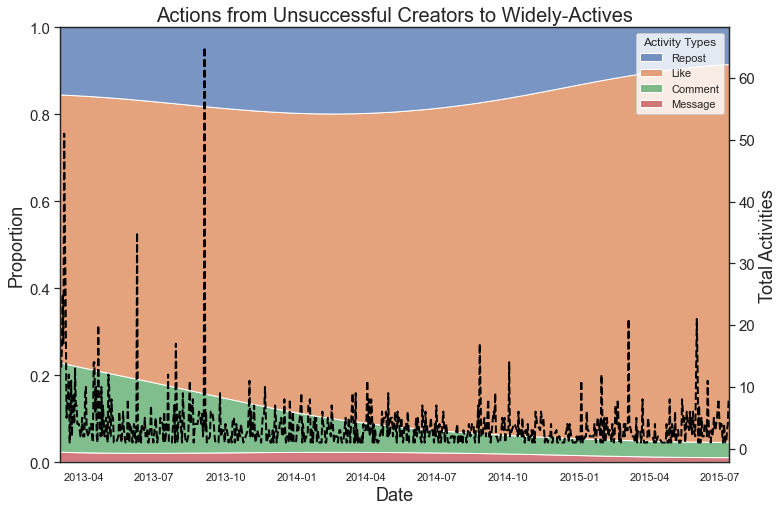

In [93]:
df = actions_sent.loc[(actions_sent.user_type == 'Widely-active')&
                      (actions_sent.creator_type == 'unsuccessful')&
                      (actions_sent.outbound_activity != 'follow'),:]

df.reset_index(inplace = True)
df.shape[0]


import seaborn as sns
hue_order_l = ['repost', 'like', 'comment', 'message']
lim_inf = min(df.date_sent)
lim_sup = max(df.date_sent)

df_grouped = df.groupby("day_yr_date", as_index = False).size()
window_size = 1
df_grouped['smoothed_size'] = pd.Series(df_grouped['size']).rolling(window_size, min_periods=1).mean()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=df,
            x="day_yr_date",
            hue='outbound_activity',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 2)\
.set(xlim=(lim_inf, lim_sup))
plt.ylabel('Proportion', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.title('Actions from Unsuccessful Creators to Widely-Actives', fontsize=20)
plt.yticks(fontsize = 15)

# Get a reference to the current legend
legend = plt.gca().get_legend()

# Set the new title for the legend
legend.set_title('Activity Types')

# Update the labels of the legend handles
for t in legend.texts:
    t.set_text(t.get_text().capitalize())

# Show the updated plot with the new legend title
    
ax2 = plt.twinx()
sns.lineplot(data=df_grouped,
            x = "day_yr_date", 
            y = "smoothed_size", 
            color="black", 
            ax=ax2, 
            legend = 'auto',
            linewidth = 2,
            linestyle = 'dashed')
plt.ylabel('Total Activities', fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

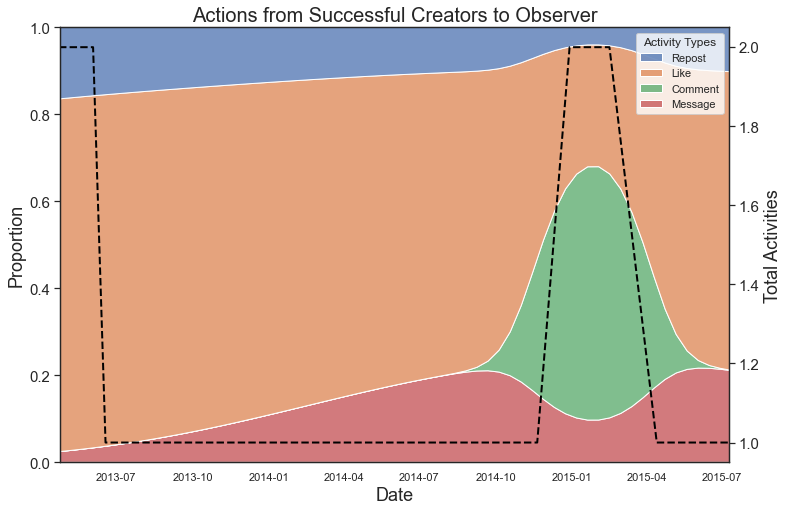

In [91]:
df = actions_sent.loc[(actions_sent.user_type == 'Observer')&
                      (actions_sent.creator_type == 'successful')&
                      (actions_sent.outbound_activity != 'follow'),:]

df.reset_index(inplace = True)
df.shape[0]


import seaborn as sns
hue_order_l = ['repost', 'like', 'comment', 'message']
lim_inf = min(df.date_sent)
lim_sup = max(df.date_sent)

df_grouped = df.groupby("day_yr_date", as_index = False).size()
window_size = 1
df_grouped['smoothed_size'] = pd.Series(df_grouped['size']).rolling(window_size, min_periods=1).mean()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=df,
            x="day_yr_date",
            hue='outbound_activity',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 2)\
.set(xlim=(lim_inf, lim_sup))
plt.ylabel('Proportion', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.title('Actions from Successful Creators to Observer', fontsize=20)
plt.yticks(fontsize = 15)

# Get a reference to the current legend
legend = plt.gca().get_legend()

# Set the new title for the legend
legend.set_title('Activity Types')

# Update the labels of the legend handles
for t in legend.texts:
    t.set_text(t.get_text().capitalize())

# Show the updated plot with the new legend title
    
ax2 = plt.twinx()
sns.lineplot(data=df_grouped,
            x = "day_yr_date", 
            y = "smoothed_size", 
            color="black", 
            ax=ax2, 
            legend = 'auto',
            linewidth = 2,
            linestyle = 'dashed')
plt.ylabel('Total Activities', fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/venv/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


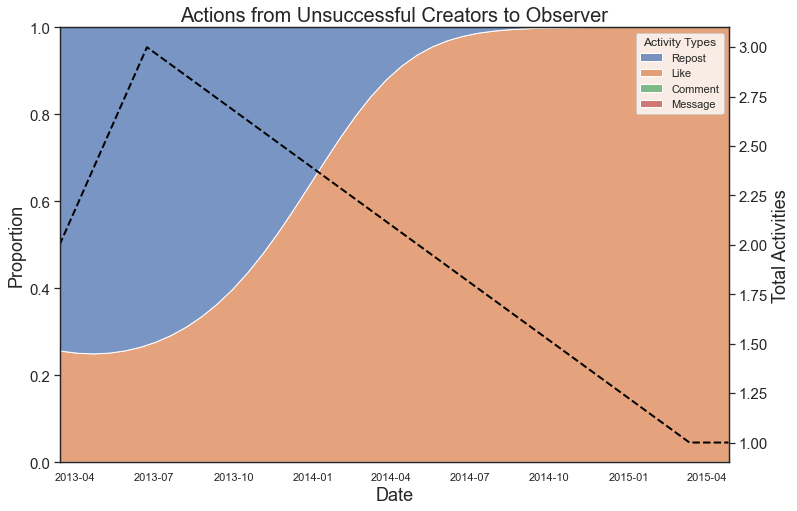

In [92]:
df = actions_sent.loc[(actions_sent.user_type == 'Observer')&
                      (actions_sent.creator_type == 'unsuccessful')&
                      (actions_sent.outbound_activity != 'follow'),:]

df.reset_index(inplace = True)
df.shape[0]


import seaborn as sns
hue_order_l = ['repost', 'like', 'comment', 'message']
lim_inf = min(df.date_sent)
lim_sup = max(df.date_sent)

df_grouped = df.groupby("day_yr_date", as_index = False).size()
window_size = 1
df_grouped['smoothed_size'] = pd.Series(df_grouped['size']).rolling(window_size, min_periods=1).mean()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("white")
sns.kdeplot(data=df,
            x="day_yr_date",
            hue='outbound_activity',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 2)\
.set(xlim=(lim_inf, lim_sup))
plt.ylabel('Proportion', fontsize = 18)
plt.xlabel('Date', fontsize = 18)
plt.title('Actions from Unsuccessful Creators to Observer', fontsize=20)
plt.yticks(fontsize = 15)

# Get a reference to the current legend
legend = plt.gca().get_legend()

# Set the new title for the legend
legend.set_title('Activity Types')

# Update the labels of the legend handles
for t in legend.texts:
    t.set_text(t.get_text().capitalize())

# Show the updated plot with the new legend title
    
ax2 = plt.twinx()
sns.lineplot(data=df_grouped,
            x = "day_yr_date", 
            y = "smoothed_size", 
            color="black", 
            ax=ax2, 
            legend = 'auto',
            linewidth = 2,
            linestyle = 'dashed')
plt.ylabel('Total Activities', fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

In [ ]:
#actions received by creators
comments_received_c = import_dta(path_dir, "12sample_comments_received.dta");
shares_received_c = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received_c = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received_c = import_dta(path_dir, "12sample_messages_received.dta");

if 'song_id' in shares_received_c:
        shares_received_c.drop(columns=["song_id"])
shares_received_c = shares_received_c[['reposter_id', "owner_id", 'created_at']]
shares_received_c['inbound_activity'] = 'share'
shares_received_c.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

if 'track_id' in likes_received_c:
        likes_received_c = likes_received_c.drop(columns=["track_id"])
likes_received_c['inbound_activity'] = 'like'
likes_received_c.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

if 'track_id' in comments_received_c:
        comments_received_c = comments_received_c.drop(columns=["track_id"])
comments_received_c['inbound_activity'] = 'comment'
comments_received_c.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

messages_received_c["outbound_activity"] = 'message'
messages_received_c.columns = ['user_id', 'fan_id', 'date_sent', 'inbound_activity']
user_activity_data_c = pd.concat([shares_received_c, likes_received_c, comments_received_c, messages_received_c])
user_activity_data_c['day_yr_date'] = user_activity_data_c.date_sent.dt.normalize()

In [ ]:
actions_sent_filtered = actions_sent.loc[(actions_sent.creator_type == 'successful')
                 &(actions_sent.user_type.isin(['Focused-active','Hermit'])
                 &(actions_sent.outbound_activity != 'follow'))] 

actions_sent_filtered2 = actions_sent.loc[(actions_sent.creator_type == 'successful')
                 &(actions_sent.user_type.isin(['Focused-active','Hermit']))]


In [ ]:
actions_sent_filtered['reward'] = np.nan
interval = 7
for user_id in tqdm(actions_sent_filtered.user_id.unique()):
    for fan_id in actions_sent_filtered.loc[actions_sent_filtered.user_id == user_id].fan_id.unique():
        actions_sent_filtered.loc[(actions_sent_filtered.user_id == user_id)&
                                  (actions_sent_filtered.fan_id == fan_id),'reward'] =\
        actions_sent_filtered.loc[(actions_sent_filtered.user_id == user_id)&
                                  (actions_sent_filtered.fan_id == fan_id)].day_yr_date.apply(
            lambda x : 1 if 
    (user_activity_data_c.loc[
    (user_activity_data_c.user_id == user_id)&
    (user_activity_data_c.fan_id == fan_id)&
    (user_activity_data_c.day_yr_date > x)&   
    (user_activity_data_c.day_yr_date <= x + datetime.timedelta(days=interval))]).shape[0]>0 else 0)
                                                          
actions_sent_filtered.sort_values(by='date_sent', inplace = True)

In [ ]:
actions_sent_filtered2['reward'] = np.nan
interval = 7
for user_id in tqdm(actions_sent_filtered2.user_id.unique()):
    for fan_id in actions_sent_filtered2.loc[actions_sent_filtered2.user_id == user_id].fan_id.unique():
        actions_sent_filtered2.loc[(actions_sent_filtered2.user_id == user_id)&
                                  (actions_sent_filtered2.fan_id == fan_id),'reward'] =\
        actions_sent_filtered2.loc[(actions_sent_filtered2.user_id == user_id)&
                                  (actions_sent_filtered2.fan_id == fan_id)].day_yr_date.apply(
            lambda x : 1 if 
    (user_activity_data_c.loc[
    (user_activity_data_c.user_id == user_id)&
    (user_activity_data_c.fan_id == fan_id)&
    (user_activity_data_c.day_yr_date > x)&   
    (user_activity_data_c.day_yr_date <= x + datetime.timedelta(days=interval))]).shape[0]>0 else 0)
                                          
actions_sent_filtered2.sort_values(by='date_sent', inplace = True)

In [ ]:
class MultiArmedBandits:
    
    def __init__(self, arm_names, user_id):
        self.user_id = user_id
        self.arm_names = arm_names
        self.arms = {k:{'Sent':0,'Reward':0} for k in arm_names}
        self.increment = {k:{'Sent':0,'Reward':0} for k in arm_names}
        self.means = np.array(len(arm_names))
        self.stds = np.array(len(arm_names))
        self.last_arm_pulled = None
        self.arm_switches = 0
        self.total_trials = 0 
        self.rewards = 0
    
    def initialize_priors(self):
        pass
    
    def update_increment(self, target, outcome):
        self.increment[target]['Sent'] += 1
        self.increment[target]['Reward'] += outcome
        self.arm_switches += self.arm_switches + (self.last_arm_pulled != str(target))
        self.last_arm_pulled = str(target)
        self.total_trials += 1
        self.rewards += outcome
    
    def update_arms(self):
        for k in self.increment.keys():
            for j in self.increment[k]:
                self.arms[k][j] += self.increment[k][j]
        self.increment = {k:{'Sent':0,'Reward':0} for k in self.arm_names}
                
    def estimate_moments(self):
        
        Sent = np.array([a[1]['Sent'] for a in self.arms.items()])
        Reward = np.array([a[1]['Reward'] for a in self.arms.items()])
        
        alpha = Reward + 1 
        beta = (Sent-Reward)+1

        mean = alpha/(alpha+beta)
        variance = (alpha*beta)/((alpha+beta+1)*((alpha+beta)**2))
        
        self.means = np.transpose(np.around(mean,10))
        self.stds = np.transpose(np.around(np.sqrt(variance),10))

In [ ]:
df = actions_sent_filtered
arm_names = ['Focused-active', 'Hermit']

fan_not_found = []

#initialize arms
bandit = MultiArmedBandits(arm_names, 'MAB')

dataset_mean = pd.DataFrame(index = range(df.shape[0]), columns = arm_names) 
dataset_std = pd.DataFrame(index = range(df.shape[0]), columns = arm_names)
    
est = {'dataset_std': dataset_std, 'dataset_mean': dataset_mean}

#update arms
for i in tqdm(range(df.shape[0])):
    try:
        user_type = df.iloc[i, -4]
        bandit.update_increment(user_type, df.iloc[i].reward)
    except KeyError:
        fan_not_found.append([fan_id, day, df_subset.iloc[action].outbound_activity])
    except IndexError:
        fan_not_found.append([fan_id, day, df_subset.iloc[action].outbound_activity])
#REWRITE THIS AS A LOOP OVER ALL USER_IDS          

    bandit.update_arms()
    bandit.estimate_moments()
    est['dataset_mean'].loc[est['dataset_mean'].index == i, :] = np.transpose(bandit.means)
    est['dataset_std'].loc[est['dataset_std'].index == i, :] = np.transpose(bandit.stds)


In [ ]:
df = actions_sent_filtered2
arm_names = ['Focused-active', 'Hermit']

fan_not_found = []

#initialize arms
bandit2 = MultiArmedBandits(arm_names, 'MAB')

dataset_mean = pd.DataFrame(index = range(df.shape[0]), columns = arm_names) 
dataset_std = pd.DataFrame(index = range(df.shape[0]), columns = arm_names)
    
est2 = {'dataset_std': dataset_std, 'dataset_mean': dataset_mean}

#update arms
for i in tqdm(range(df.shape[0])):
    try:
        user_type = df.iloc[i, -4]
        bandit2.update_increment(user_type, df.iloc[i].reward)
    except KeyError:
        fan_not_found.append([fan_id, day, df.iloc[action].outbound_activity])
    except IndexError:
        fan_not_found.append([fan_id, day, df.iloc[action].outbound_activity])
#REWRITE THIS AS A LOOP OVER ALL USER_IDS          

    bandit2.update_arms()
    bandit2.estimate_moments()
    est2['dataset_mean'].loc[est2['dataset_mean'].index == i, :] = np.transpose(bandit2.means)
    est2['dataset_std'].loc[est2['dataset_std'].index == i, :] = np.transpose(bandit2.stds)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(est['dataset_mean'], linewidth = 2)
plt.fill_between(range(len(est['dataset_mean'])),
                 (est['dataset_mean']['Focused-active'] - (1.96 * est['dataset_std']['Focused-active'])).tolist(),
                 (est['dataset_mean']['Focused-active'] + (1.96 * est['dataset_std']['Focused-active'])).tolist(),
                 alpha=0.2, color='blue')

plt.fill_between(range(len(est['dataset_mean'])),
                 (est['dataset_mean']['Hermit'] - (1.96 * (est['dataset_std'])['Hermit'])).tolist(),
                 (est['dataset_mean']['Hermit'] + (1.96 * (est['dataset_std'])['Hermit'])).tolist(),
                 alpha=0.2, color='orange')

#plt.title('Learning Trajectories', fontsize = 18)
plt.xlabel('Outbound Activities', fontsize = 18)
plt.xticks(fontsize=14)
plt.ylabel('Expected Reward', fontsize = 18)
plt.yticks(fontsize=14)

plt.legend(['Focused-Active', 'Hermit'], fontsize = 18)
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.show()


In [ ]:
sns.lineplot(data=est2['dataset_mean'])

plt.xlabel('Trials')
plt.ylabel('Expected Reward')

#plt.title('')
plt.legend(['Focused-active', 'Hermit'])
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.show()

In [ ]:
sns.lineplot(data=est2['dataset_std'])

plt.xlabel('Trials')
plt.ylabel('Variance')

#plt.title('')
plt.legend(['Focused-active', 'Hermit'])
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.show()

In [ ]:
actions_sent_filtered3 = actions_sent.loc[(actions_sent.creator_type == 'successful')
                 &(actions_sent.user_type.isin(['Focused-active','Observer'])
                 &(actions_sent.outbound_activity != 'follow'))]

In [ ]:
actions_sent_filtered3['reward'] = np.nan
interval = 7
for user_id in tqdm(actions_sent_filtered3.user_id.unique()):
    for fan_id in actions_sent_filtered3.loc[actions_sent_filtered3.user_id == user_id].fan_id.unique():
        actions_sent_filtered3.loc[(actions_sent_filtered3.user_id == user_id)&
                                  (actions_sent_filtered3.fan_id == fan_id),'reward'] =\
        actions_sent_filtered3.loc[(actions_sent_filtered3.user_id == user_id)&
                                  (actions_sent_filtered3.fan_id == fan_id)].day_yr_date.apply(
            lambda x : 1 if 
    (user_activity_data_c.loc[
    (user_activity_data_c.user_id == user_id)&
    (user_activity_data_c.fan_id == fan_id)&
    (user_activity_data_c.day_yr_date > x)&   
    (user_activity_data_c.day_yr_date <= x + datetime.timedelta(days=interval))]).shape[0]>0 else 0)  
        
actions_sent_filtered3.sort_values(by='date_sent', inplace = True)

In [ ]:
df = actions_sent_filtered3
arm_names = ['Focused-active', 'Observer']

fan_not_found = []

#initialize arms
bandit3 = MultiArmedBandits(arm_names, 'MAB')

dataset_mean = pd.DataFrame(index = range(df.shape[0]), columns = arm_names) 
dataset_std = pd.DataFrame(index = range(df.shape[0]), columns = arm_names)
    
est3 = {'dataset_std': dataset_std, 'dataset_mean': dataset_mean}

#update arms
for i in tqdm(range(df.shape[0])):
    try:
        user_type = df.iloc[i, -4]
        bandit3.update_increment(user_type, df.iloc[i].reward)
    except KeyError:
        fan_not_found.append(df.iloc[i, 1])
    except IndexError:
        fan_not_found.append(df.iloc[i, 1])
#REWRITE THIS AS A LOOP OVER ALL USER_IDS          

    bandit3.update_arms()
    bandit3.estimate_moments()
    est3['dataset_mean'].loc[est3['dataset_mean'].index == i, :] = np.transpose(bandit3.means)
    est3['dataset_std'].loc[est3['dataset_std'].index == i, :] = np.transpose(bandit3.stds)

In [ ]:
sns.lineplot(data=est3['dataset_mean'])

plt.xlabel('Trials')
plt.ylabel('Expected Reward')

#plt.title('')
plt.legend(['Focused-active', 'Observer'])
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.show()

In [ ]:
sns.lineplot(data=est3['dataset_std'])

plt.xlabel('Trials')
plt.ylabel('Variance')

#plt.title('')
plt.legend(['Focused-active', 'Observer'])
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.show()

In [ ]:
actions_sent_filtered4 = actions_sent.loc[(actions_sent.creator_type == 'successful')
                 &(actions_sent.user_type.isin(['Focused-active', 'Widely-active', 'Observer', 'Hermit'])
                 &(actions_sent.outbound_activity != 'follow'))]

actions_sent_filtered4['reward'] = np.nan
interval = 7
for user_id in tqdm(actions_sent_filtered4.user_id.unique()):
    for fan_id in actions_sent_filtered4.loc[actions_sent_filtered4.user_id == user_id].fan_id.unique():
        actions_sent_filtered4.loc[(actions_sent_filtered4.user_id == user_id)&
                                  (actions_sent_filtered4.fan_id == fan_id),'reward'] =\
        actions_sent_filtered4.loc[(actions_sent_filtered4.user_id == user_id)&
                                  (actions_sent_filtered4.fan_id == fan_id)].day_yr_date.apply(
            lambda x : 1 if 
    (user_activity_data_c.loc[
    (user_activity_data_c.user_id == user_id)&
    (user_activity_data_c.fan_id == fan_id)&
    (user_activity_data_c.day_yr_date > x)&   
    (user_activity_data_c.day_yr_date <= x + datetime.timedelta(days=interval))]).shape[0]>0 else 0)

actions_sent_filtered4.sort_values(by='date_sent', inplace = True)

In [ ]:
actions_sent_filtered4.groupby('user_type').user_id.nunique()

In [ ]:
df = actions_sent_filtered4
arm_names = ['Focused-active', 'Widely-active', 'Observer', 'Hermit']

fan_not_found = []

#initialize arms
bandit4 = MultiArmedBandits(arm_names, 'MAB')

dataset_mean = pd.DataFrame(index = range(df.shape[0]), columns = arm_names) 
dataset_std = pd.DataFrame(index = range(df.shape[0]), columns = arm_names)
    
est4 = {'dataset_std': dataset_std, 'dataset_mean': dataset_mean}

#update arms
for i in tqdm(range(df.shape[0])):
    try:
        user_type = df.iloc[i, -4]
        bandit4.update_increment(user_type, df.iloc[i].reward)
    except KeyError:
        fan_not_found.append(df.iloc[i, 1])
    except IndexError:
        fan_not_found.append(df.iloc[i, 1])
#REWRITE THIS AS A LOOP OVER ALL USER_IDS          

    bandit4.update_arms()
    bandit4.estimate_moments()
    est4['dataset_mean'].loc[est4['dataset_mean'].index == i, :] = np.transpose(bandit4.means)
    est4['dataset_std'].loc[est4['dataset_std'].index == i, :] = np.transpose(bandit4.stds)


In [ ]:
sns.lineplot(data=est4['dataset_mean'])

plt.xlabel('Trials')
plt.ylabel('Expected Reward')

#plt.title('')
plt.legend(['Focused-active', 'Widely-active', 'Observer', 'Hermit'])
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.show()

In [ ]:
sns.lineplot(data=est4['dataset_std'])

plt.xlabel('Trials')
plt.ylabel('variance')

#plt.title('')
plt.legend(['Focused-active', 'Widely-active', 'Observer', 'Hermit'])
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.show()

In [ ]:
bandit4.arms

In [ ]:
actions_sent_filtered4.groupby('user_type').size()

In [ ]:
test = pd.read_csv('/Users/caiorego/Downloads/Order150.xls')

In [ ]:
test